In [1]:
#!pip install wing
#!pip install umap-learn
#!pip install hdbscan
# !pip install plotly_express

In [30]:
import pandas as pd, numpy as np
import wing
from wing.pd_utils import da
from wing.preprocess import numericalize, train_cats, add_datepart, proc_df
from sklearn.preprocessing import scale
import umap
import plotly_express
import hdbscan
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import silhouette_score, silhouette_samples
%matplotlib inline 
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
plt.rcParams["figure.figsize"] = (14,10)
path_data = "./data/"

## Preprocessing 

In [3]:
df = pd.read_csv(path_data + 'sipri-report-explosions.csv')
df.date = list(map(lambda x: ('19' + str(x)), df.date))
df.date = pd.to_datetime(df.date, format='%Y%m%d')
add_datepart(df, 'date', drop=True)

In [4]:
# Replace missing values with 0 for yield columns 
df.yield_1[df.yield_1.isna()] = df.yield_1.mean()
df.yield_u[df.yield_u.isna()] = df.yield_u.mean()

/Users/tomroth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/tomroth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [5]:
df['hour'] = list(map(lambda x: str(x)[0:2],df.origin_t))
df['hour'] = list(map(lambda x: '0' if x.find('.') != -1  else x, df['hour']))
df['hour'] = list(map(lambda x: str(x[0]) if int(x) >= 24 else x, df['hour']))

In [6]:
atmospheric_c = ['ATMOSPH','AIRDROP','TOWER','BALLOON','SURFACE','BARGE','ROCKET',
                'CRATER', 'UW', 'SPACE', 'WATER SU','SHIP','WATERSUR']
underground_c = ['SHAFT', 'TUNNEL', 'SHAFT/GR', 'SHAFT/LG','UG','GALLERY','MINE']
def preprocess_type(x): 
    if   x in atmospheric_c: return 'ATMOSPHERIC'
    elif x in underground_c: return 'UNDERGROUND'
    else:                    return 'uncategorized'
df['type_cat'] = list(map(preprocess_type, df.type))

In [7]:
# indicator variables 
df['mb_I'] = list(map(lambda x: 1 if x > 0 else 0, df['mb']))
df['Ms_I'] = list(map(lambda x: 1 if x > 0 else 0, df['Ms']))

In [8]:
key = 'id_no'
df.set_index(key, inplace=True)
df1=df.copy()

In [9]:
train_cats(df)  # str --> category 
cols_to_numericalize = ['country', 'region', 'source', 'purpose', 'type_cat']
for c in cols_to_numericalize: 
    numericalize(df, df[c], c + "_code", None)
dropcols = cols_to_numericalize + \
    ['name', 'date_long', 'origin_t', '_Year', '_Is_month_end', '_Is_month_start', 
    '_Is_year_end', '_Is_year_start','_Is_quarter_end', '_Is_quarter_start', '_Elapsed']
df.drop(columns = dropcols, inplace=True)

In [10]:
# scientific viewpoint 
keepcols = ['mb', 'Ms', 'depth', 'yield_1', 'yield_u', 'year', 'country_code', 'type_cat_code']
df_env = df[keepcols]
df_env_s =  (df_env-df_env.mean())/df_env.std()

## Dimensionality reduction 

In [25]:
fit = umap.UMAP(n_neighbors=60, n_components=3, min_dist=0.01)
%time u = fit.fit_transform(df_env_s)

/Users/tomroth/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



CPU times: user 9.26 s, sys: 150 ms, total: 9.41 s
Wall time: 9.02 s


In [26]:
df1['x'],df1['y'],df1['z'] = u[:,0],u[:,1],u[:,2]

In [29]:
# 2d scatterplot
plotly_express.scatter_3d(df1,x='x',y='y',z='z', color='country', 
                       hover_data=['year','country','type','type_cat','region','year'])

### Clustering 

In [ ]:
df_coords = df1.loc[:, ['x','y','z']]

In [48]:
def make_silhouette_plot(data, labels): 
    """Plots silhouette plot given some labels"""
    n_clusters = len(pd.Series(labels).value_counts())
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(data.values, labels)
    print("For min_cluster_size =", min_cluster_size, "and min_samples =", min_samples,
          "\n There are this many clusters: ", n_clusters, 
          "\n The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(data.values, labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
    ax2.scatter(data.iloc[:, 0], data.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for  clustering on sample data "
                  "with min_cluster_size = %d and min_samples = %d" % (min_cluster_size, min_samples)),
                 fontsize=14, fontweight='bold')
    plt.show()
    percent_classified = sum(labels != 0) / len(labels)
    return (n_clusters, silhouette_avg, percent_classified)

For min_cluster_size = 10 and min_samples = 10 
 There are this many clusters:  61 
 The average silhouette_score is : 0.6782028117307615


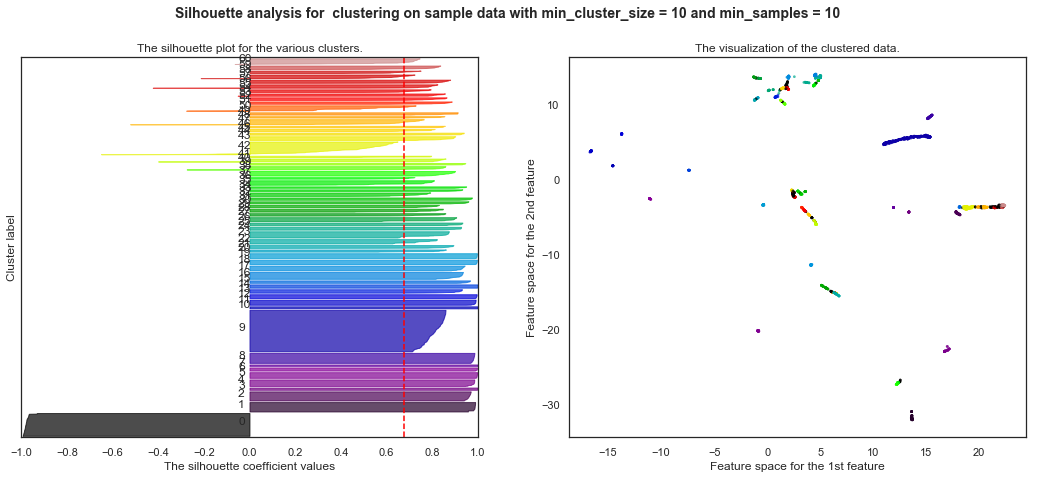

For min_cluster_size = 10 and min_samples = 15 
 There are this many clusters:  38 
 The average silhouette_score is : 0.7575407366003583


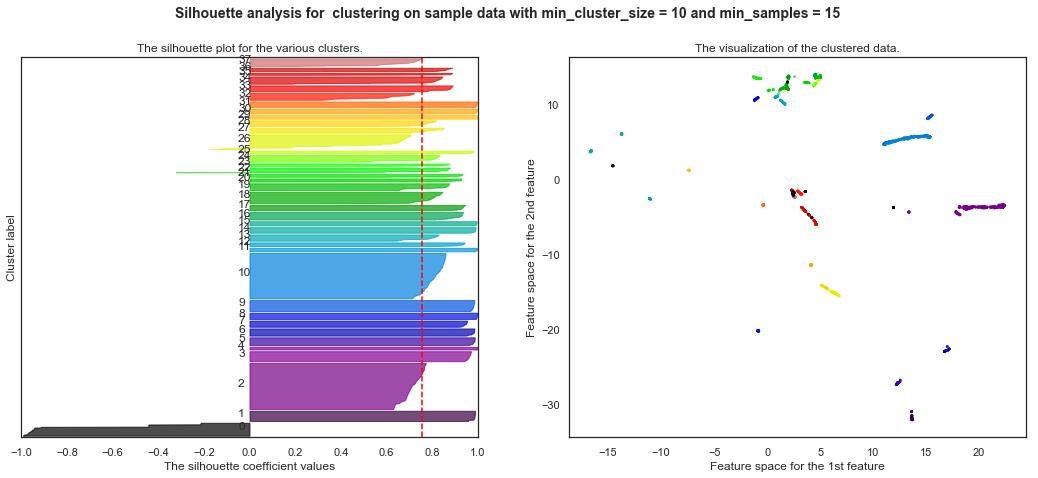

For min_cluster_size = 10 and min_samples = 20 
 There are this many clusters:  29 
 The average silhouette_score is : 0.8184182767124306


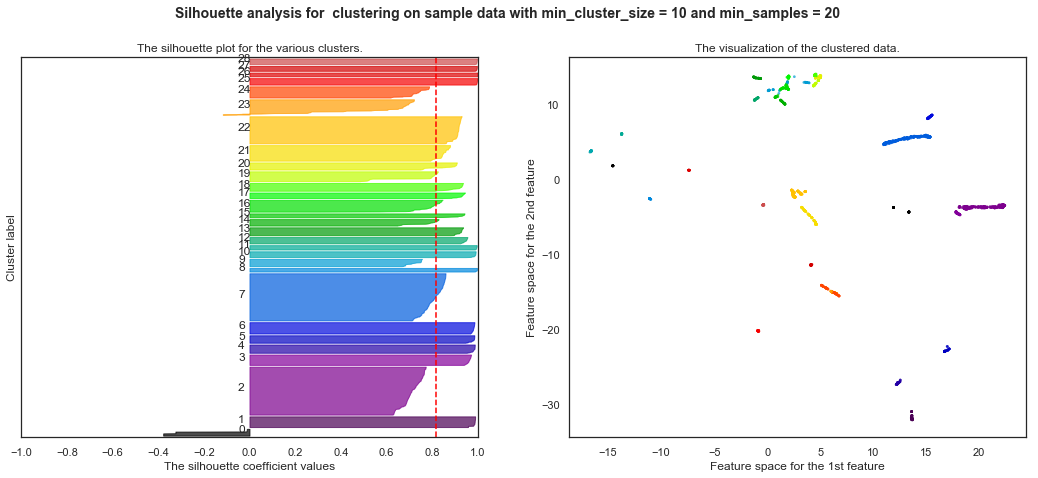

For min_cluster_size = 10 and min_samples = 25 
 There are this many clusters:  26 
 The average silhouette_score is : 0.7868930627583139


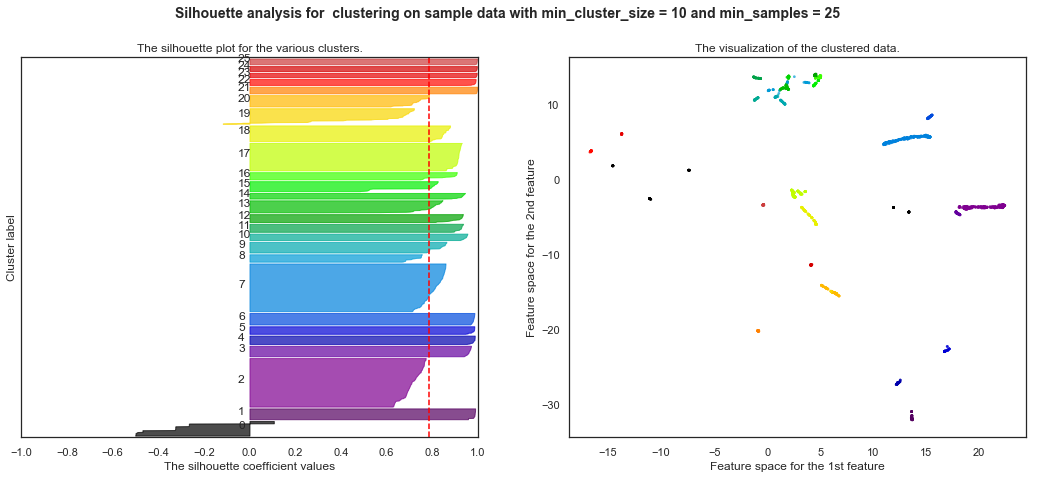

For min_cluster_size = 10 and min_samples = 30 
 There are this many clusters:  25 
 The average silhouette_score is : 0.7938319143357214


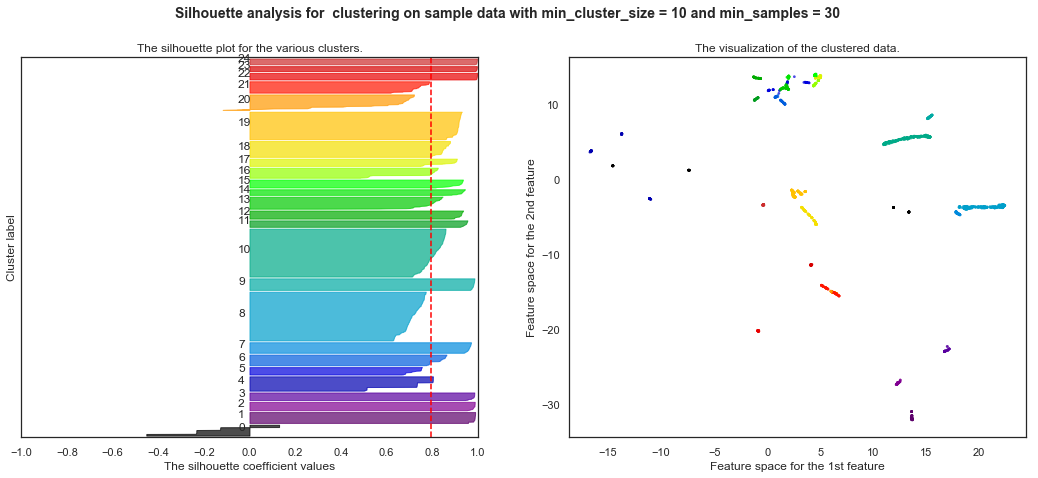

For min_cluster_size = 10 and min_samples = 35 
 There are this many clusters:  22 
 The average silhouette_score is : 0.7987732060125146


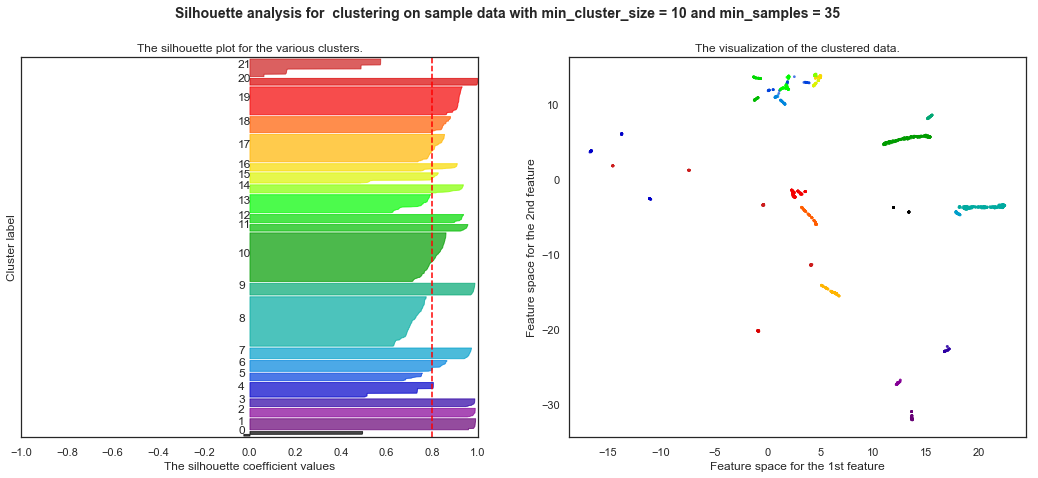

For min_cluster_size = 15 and min_samples = 10 
 There are this many clusters:  43 
 The average silhouette_score is : 0.7379297071113674


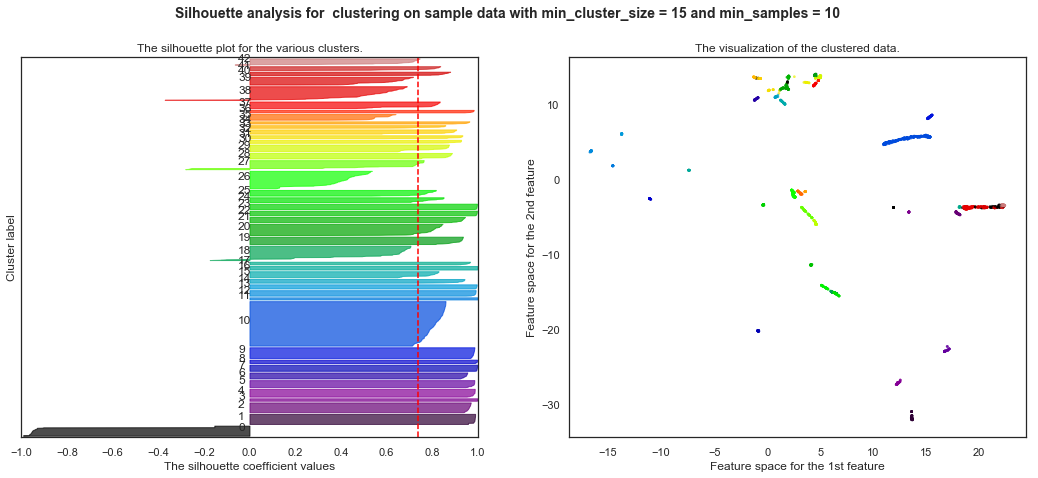

For min_cluster_size = 15 and min_samples = 15 
 There are this many clusters:  36 
 The average silhouette_score is : 0.766803399102065


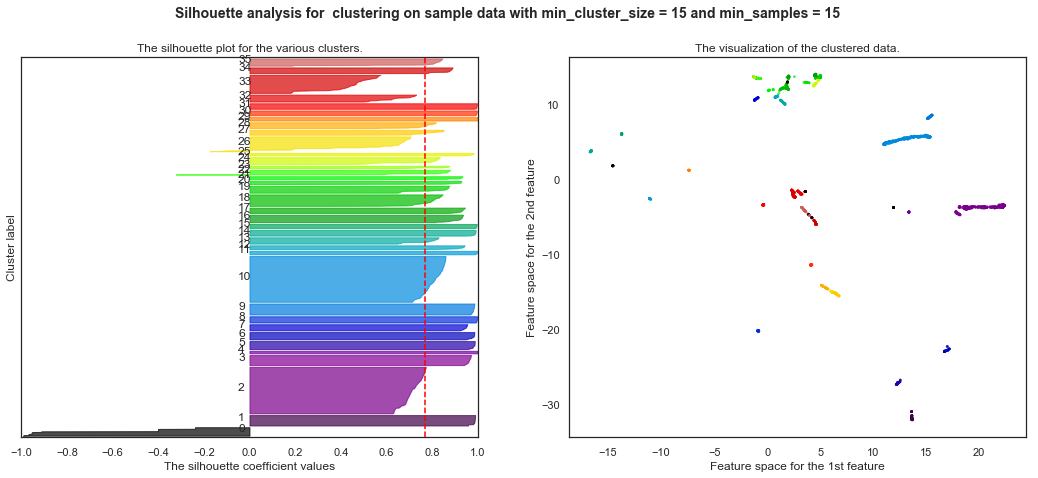

For min_cluster_size = 15 and min_samples = 20 
 There are this many clusters:  29 
 The average silhouette_score is : 0.8184182767124306


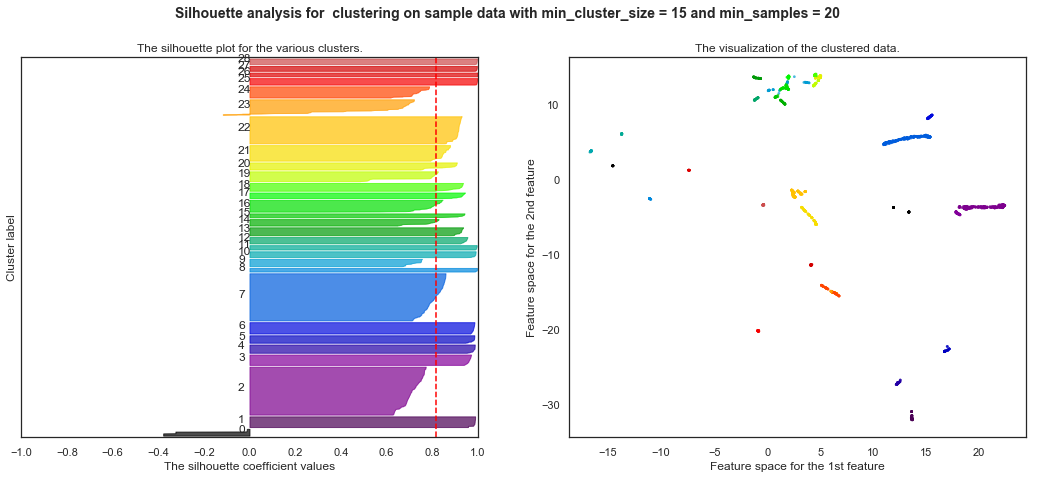

For min_cluster_size = 15 and min_samples = 25 
 There are this many clusters:  26 
 The average silhouette_score is : 0.7868930627583139


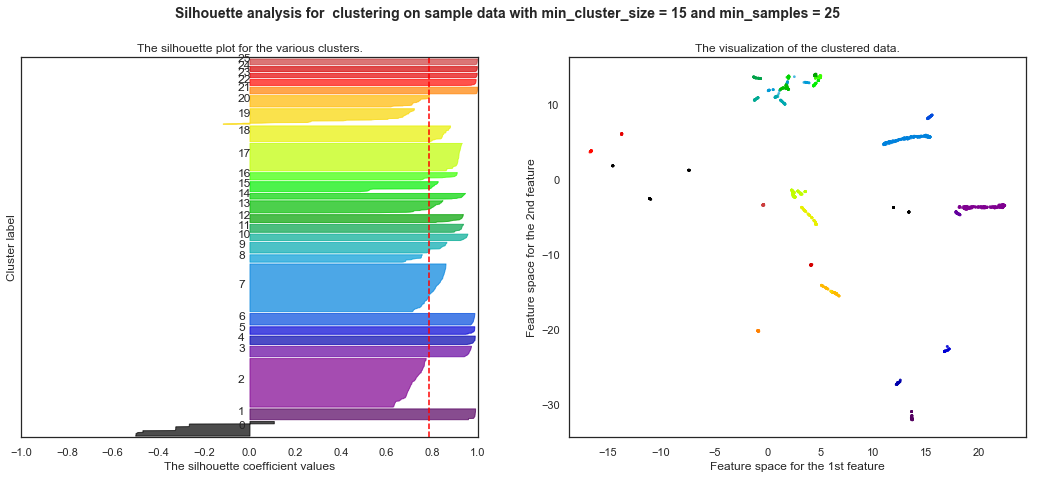

For min_cluster_size = 15 and min_samples = 30 
 There are this many clusters:  25 
 The average silhouette_score is : 0.7938319143357214


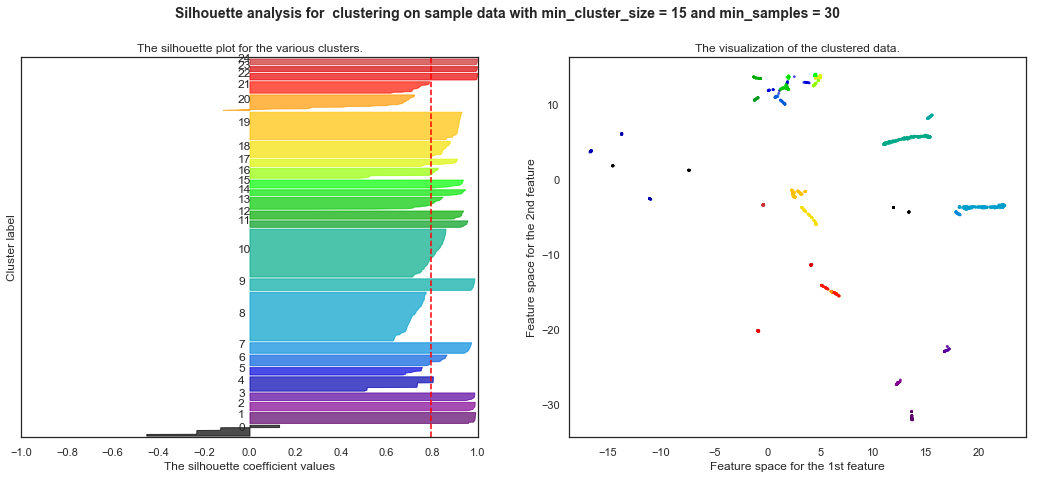

For min_cluster_size = 15 and min_samples = 35 
 There are this many clusters:  22 
 The average silhouette_score is : 0.7987732060125146


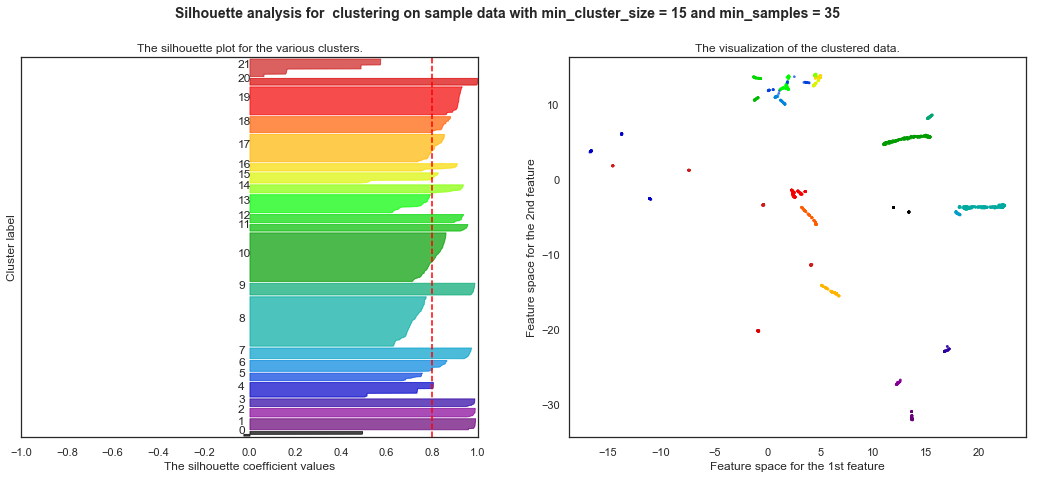

For min_cluster_size = 20 and min_samples = 10 
 There are this many clusters:  32 
 The average silhouette_score is : 0.7768984117368788


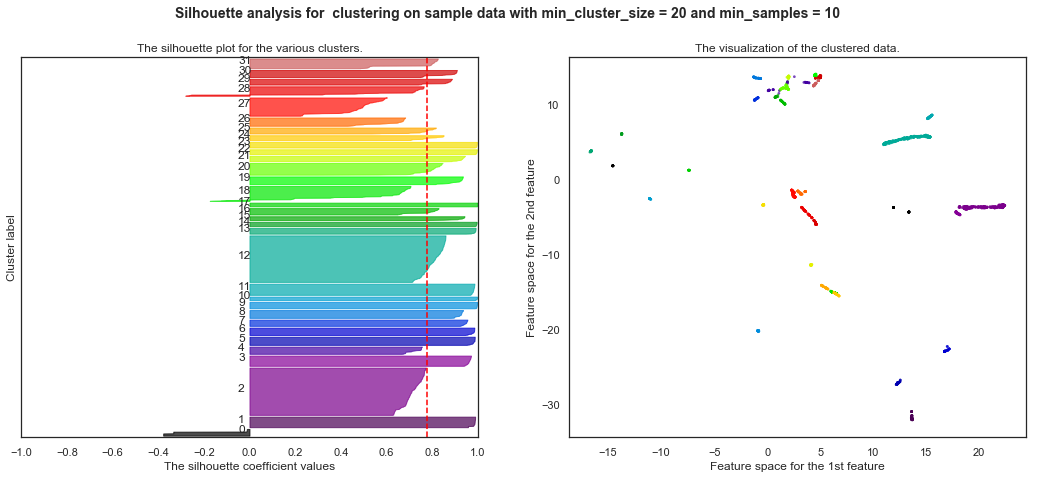

For min_cluster_size = 20 and min_samples = 15 
 There are this many clusters:  32 
 The average silhouette_score is : 0.7635070882069613


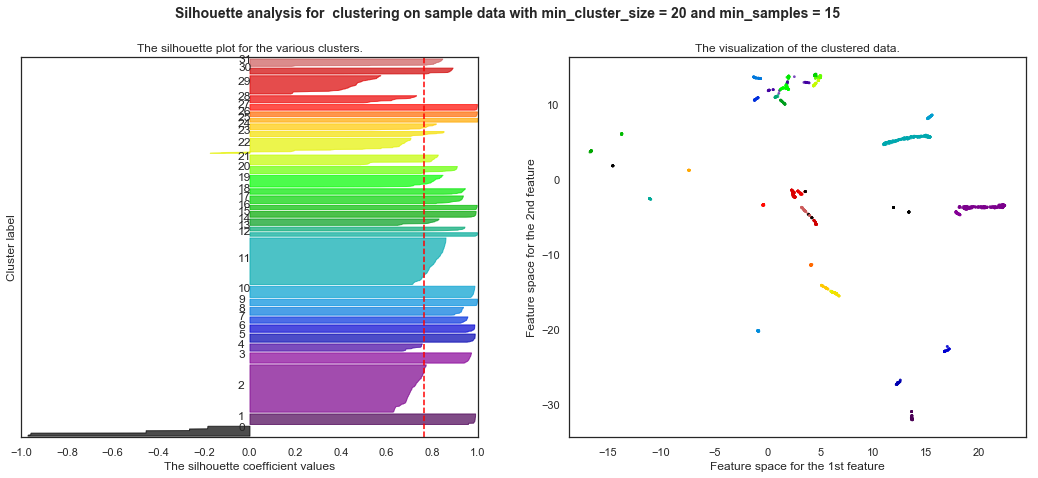

For min_cluster_size = 20 and min_samples = 20 
 There are this many clusters:  29 
 The average silhouette_score is : 0.8184182767124306


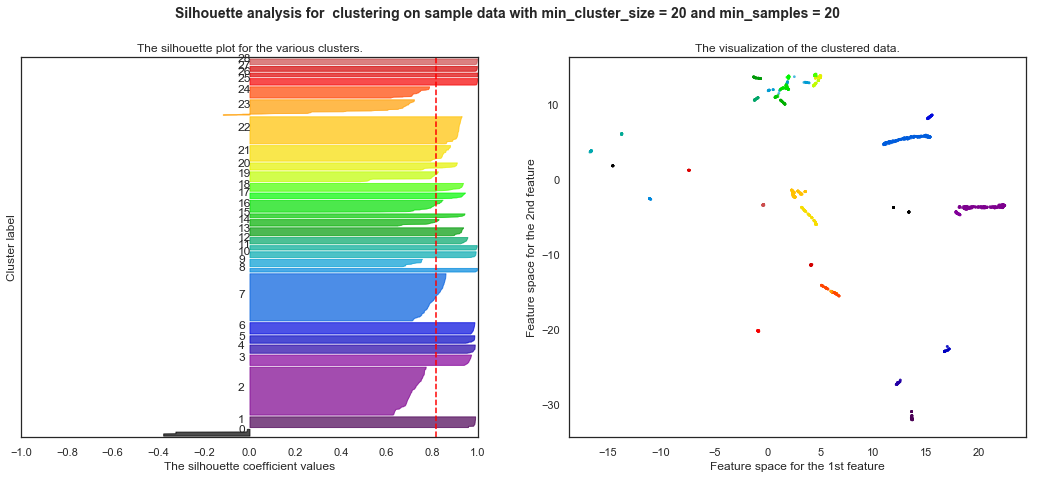

For min_cluster_size = 20 and min_samples = 25 
 There are this many clusters:  26 
 The average silhouette_score is : 0.7868930627583139


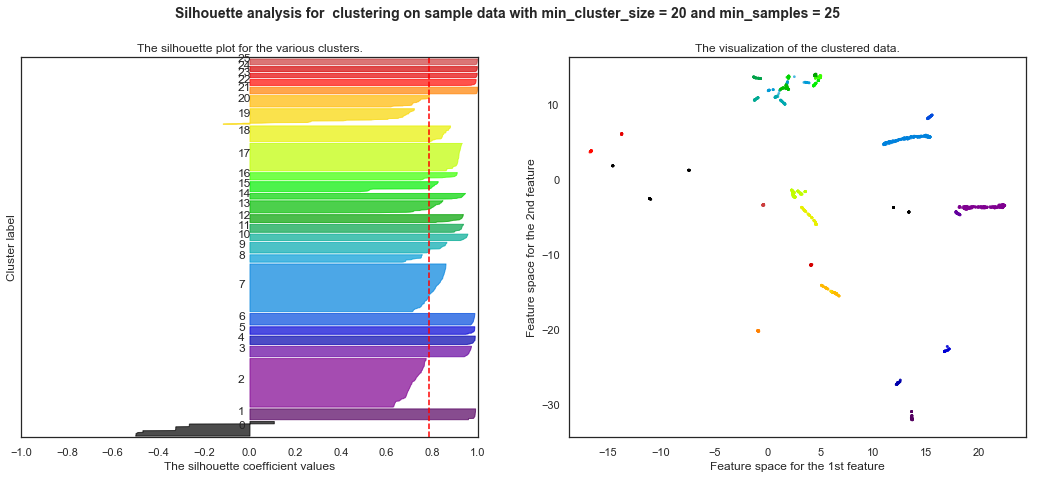

For min_cluster_size = 20 and min_samples = 30 
 There are this many clusters:  25 
 The average silhouette_score is : 0.7938319143357214


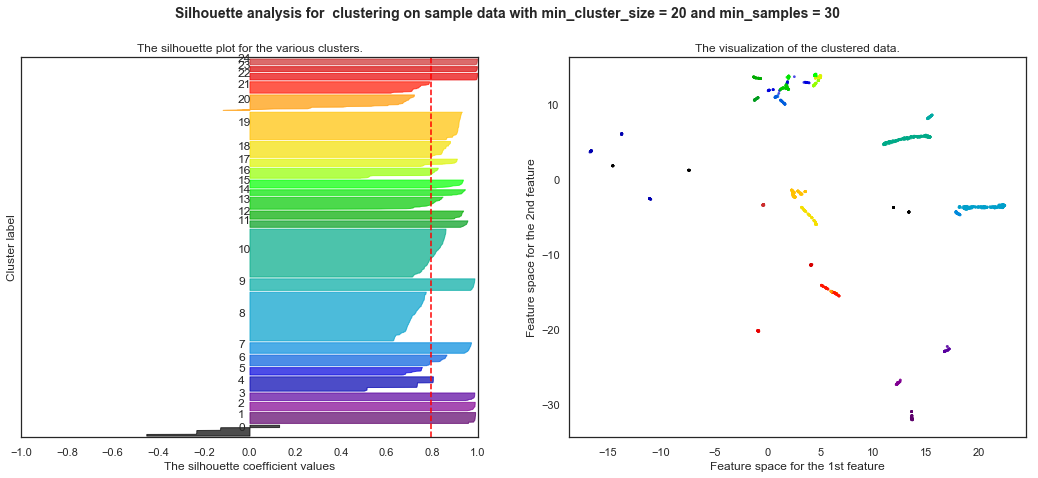

For min_cluster_size = 20 and min_samples = 35 
 There are this many clusters:  22 
 The average silhouette_score is : 0.7987732060125146


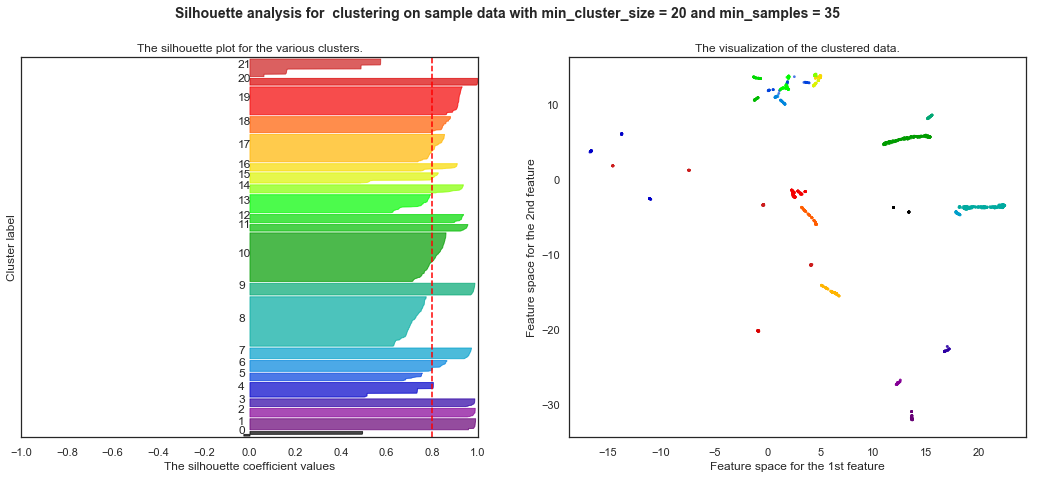

For min_cluster_size = 25 and min_samples = 10 
 There are this many clusters:  29 
 The average silhouette_score is : 0.7540377039960725


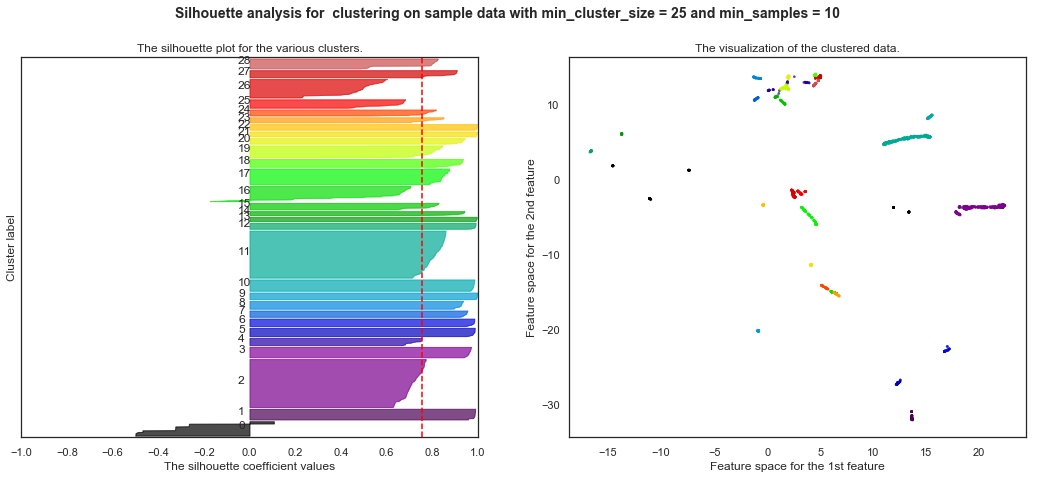

For min_cluster_size = 25 and min_samples = 15 
 There are this many clusters:  29 
 The average silhouette_score is : 0.7458936962499998


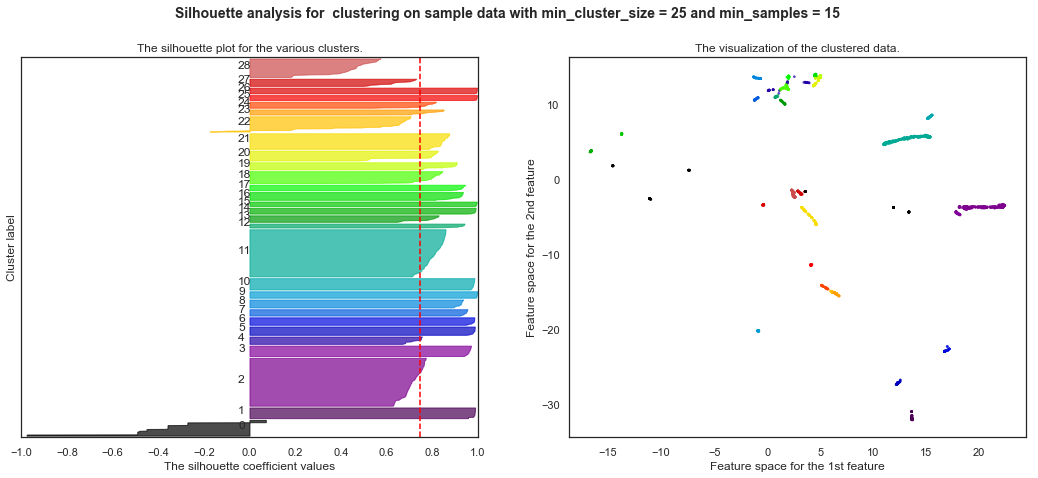

For min_cluster_size = 25 and min_samples = 20 
 There are this many clusters:  28 
 The average silhouette_score is : 0.7372711356256726


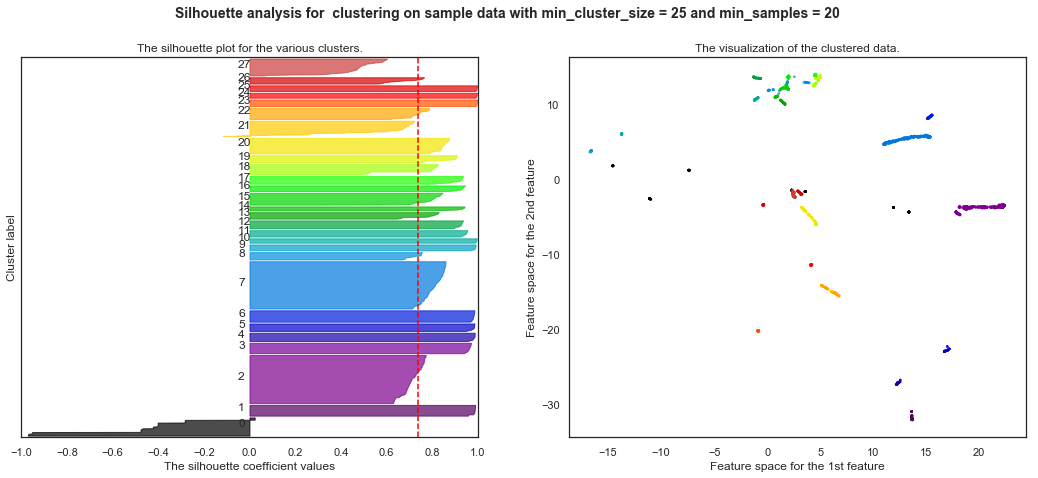

For min_cluster_size = 25 and min_samples = 25 
 There are this many clusters:  26 
 The average silhouette_score is : 0.7868930627583139


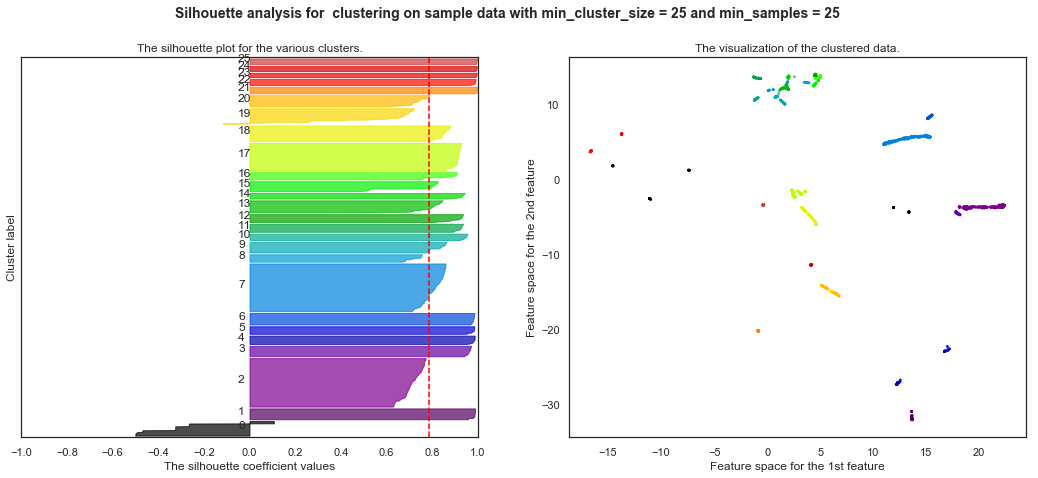

For min_cluster_size = 25 and min_samples = 30 
 There are this many clusters:  25 
 The average silhouette_score is : 0.7938319143357214


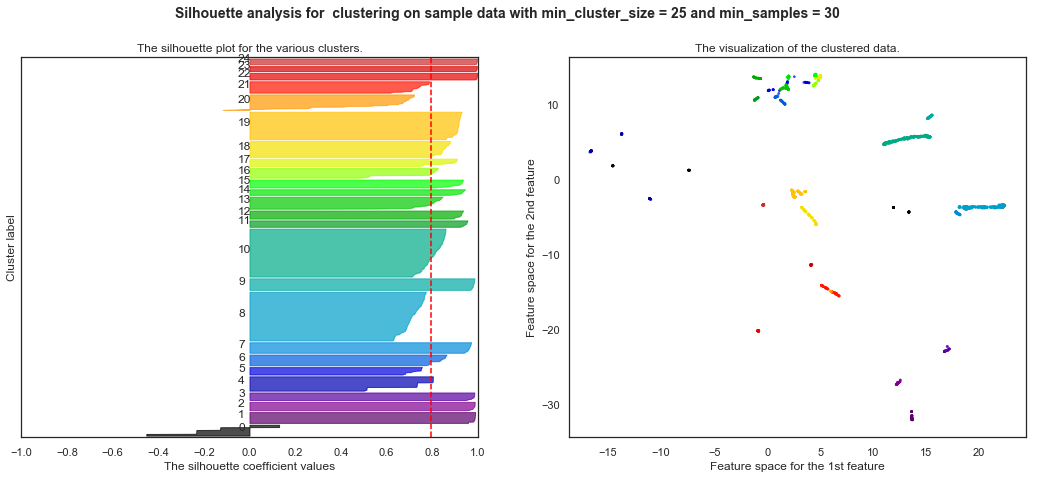

For min_cluster_size = 25 and min_samples = 35 
 There are this many clusters:  22 
 The average silhouette_score is : 0.7987732060125146


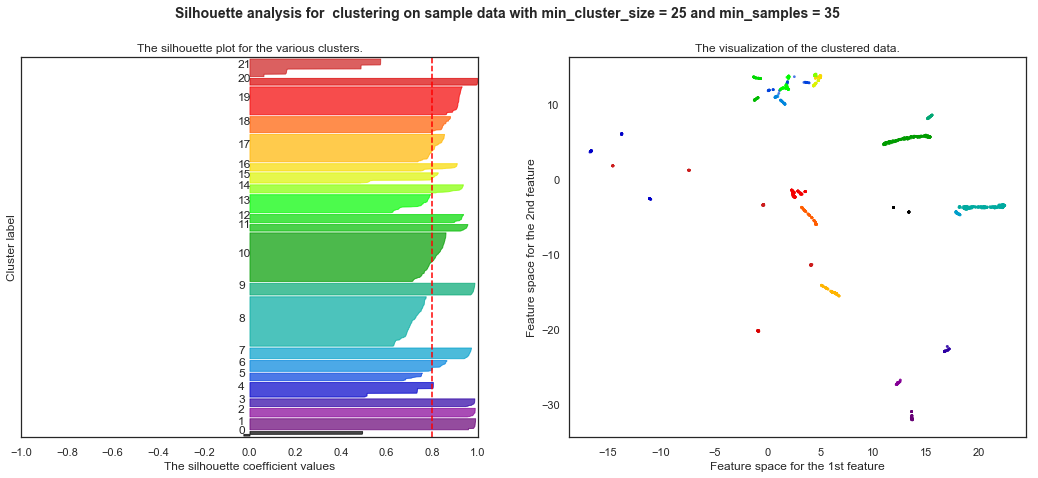

For min_cluster_size = 30 and min_samples = 10 
 There are this many clusters:  27 
 The average silhouette_score is : 0.7609180488306297


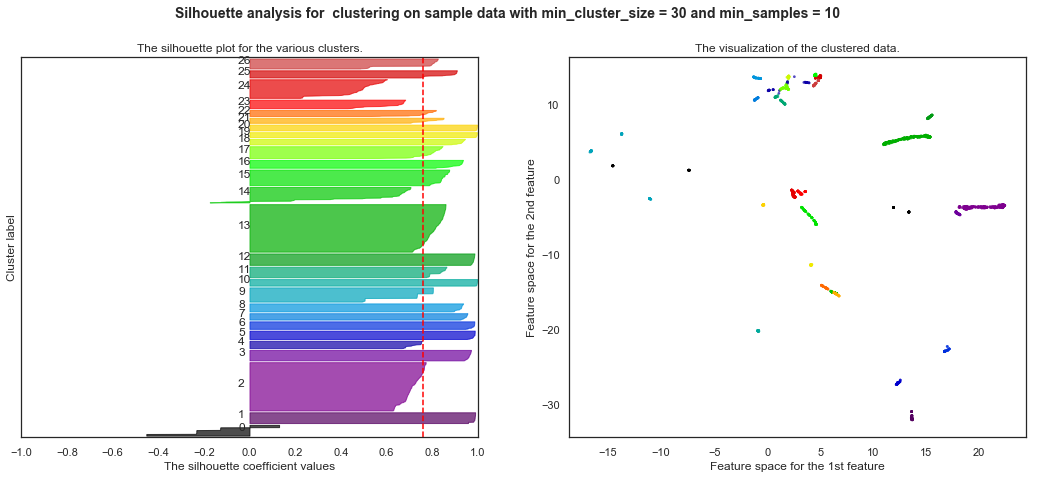

For min_cluster_size = 30 and min_samples = 15 
 There are this many clusters:  26 
 The average silhouette_score is : 0.7523806894718098


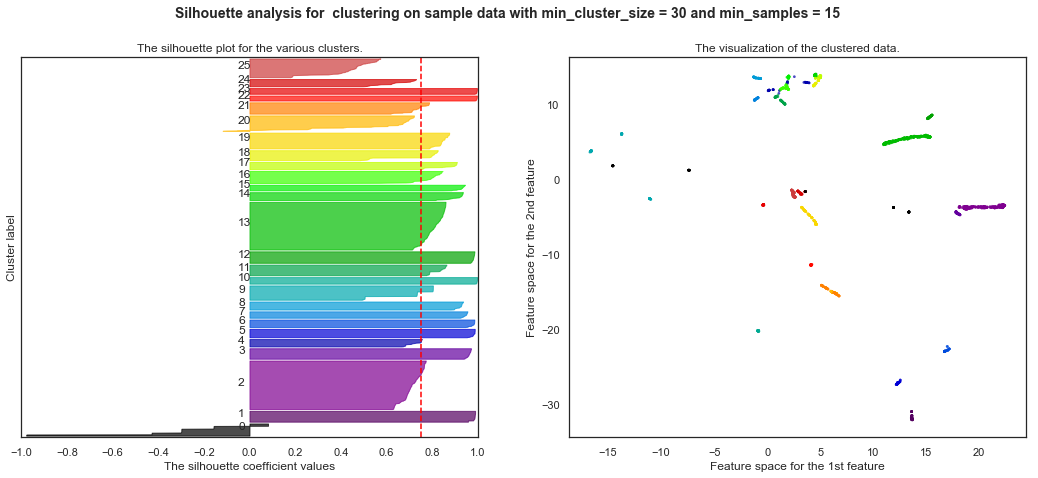

For min_cluster_size = 30 and min_samples = 20 
 There are this many clusters:  25 
 The average silhouette_score is : 0.7938319143357214


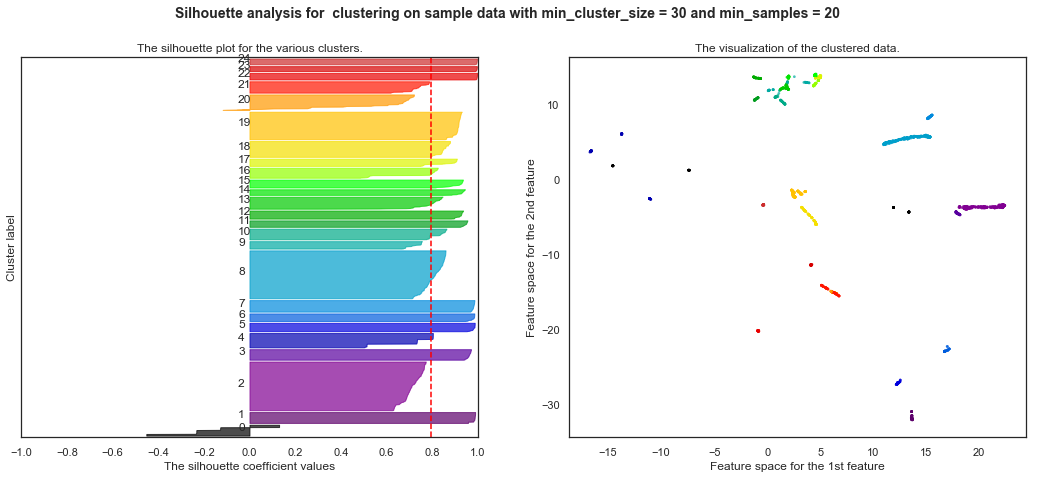

For min_cluster_size = 30 and min_samples = 25 
 There are this many clusters:  25 
 The average silhouette_score is : 0.7938319143357214


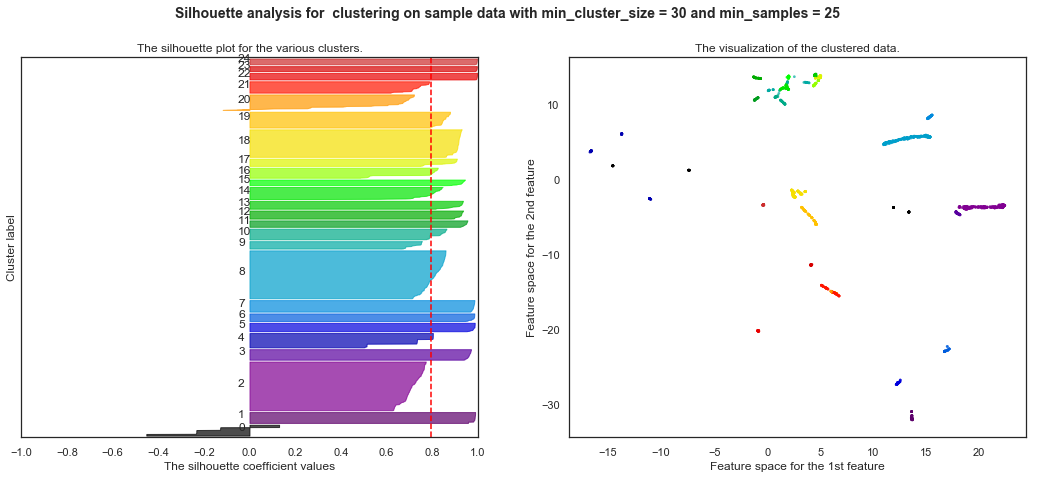

For min_cluster_size = 30 and min_samples = 30 
 There are this many clusters:  25 
 The average silhouette_score is : 0.7938319143357214


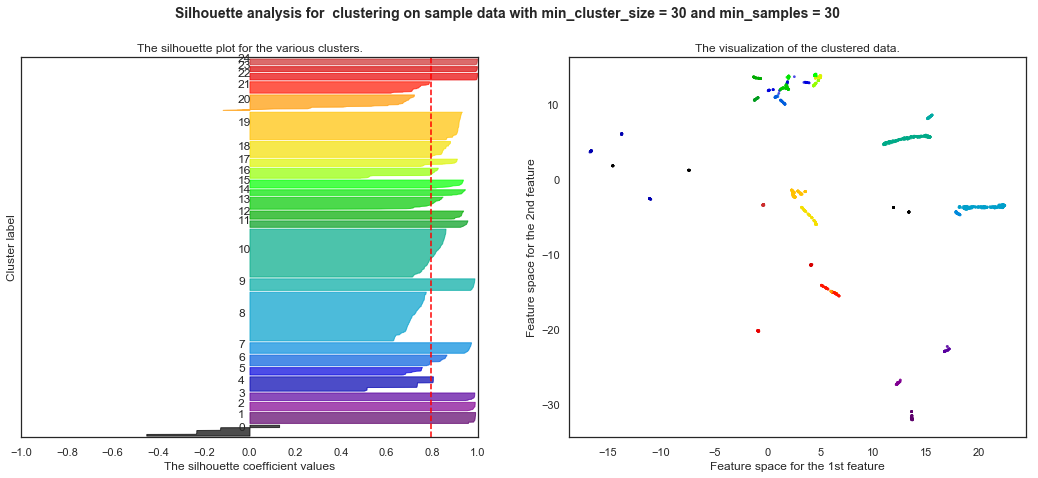

For min_cluster_size = 30 and min_samples = 35 
 There are this many clusters:  22 
 The average silhouette_score is : 0.7987732060125146


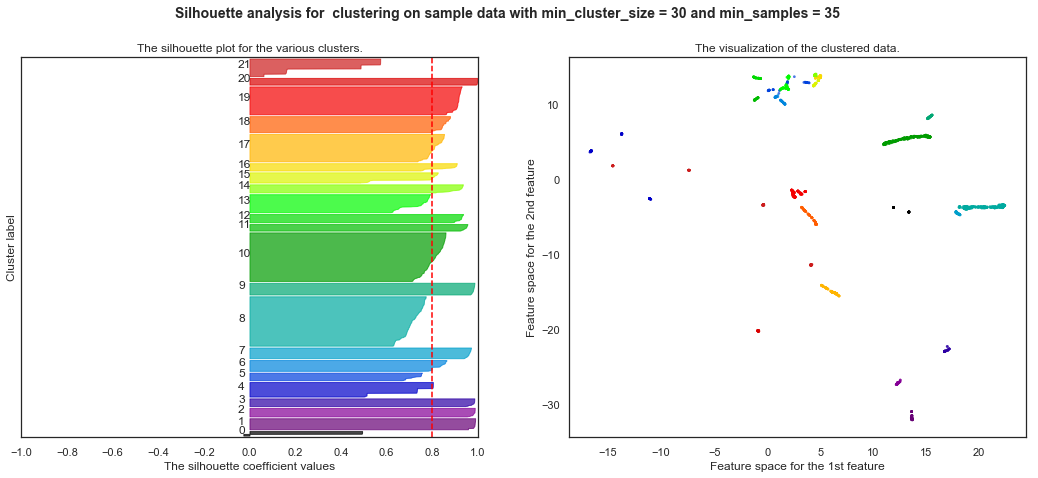

For min_cluster_size = 35 and min_samples = 10 
 There are this many clusters:  25 
 The average silhouette_score is : 0.7566075711971988


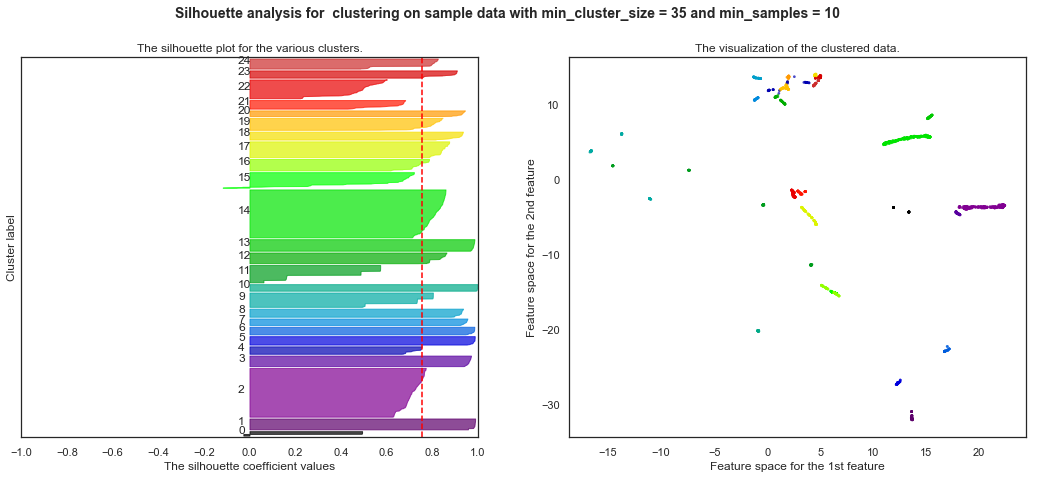

For min_cluster_size = 35 and min_samples = 15 
 There are this many clusters:  25 
 The average silhouette_score is : 0.7473960754671644


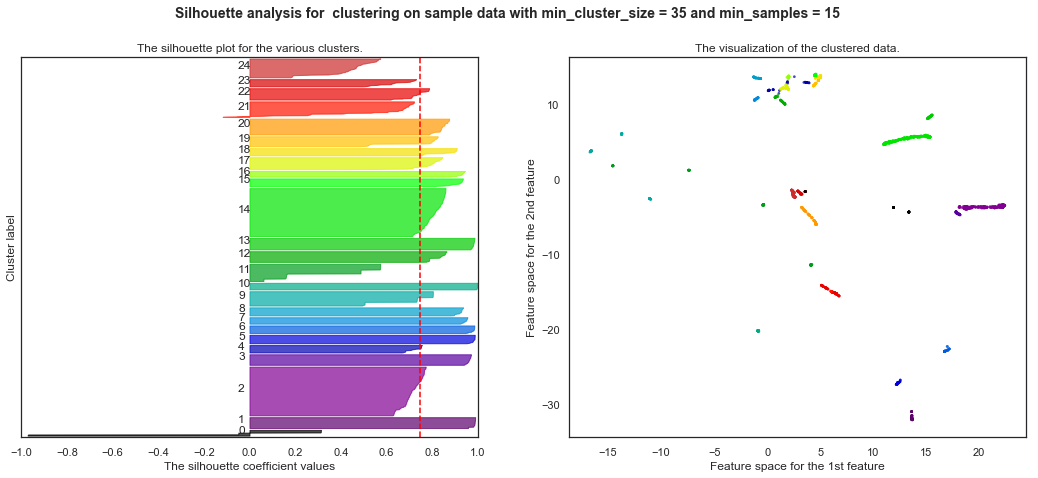

For min_cluster_size = 35 and min_samples = 20 
 There are this many clusters:  24 
 The average silhouette_score is : 0.7891988917202911


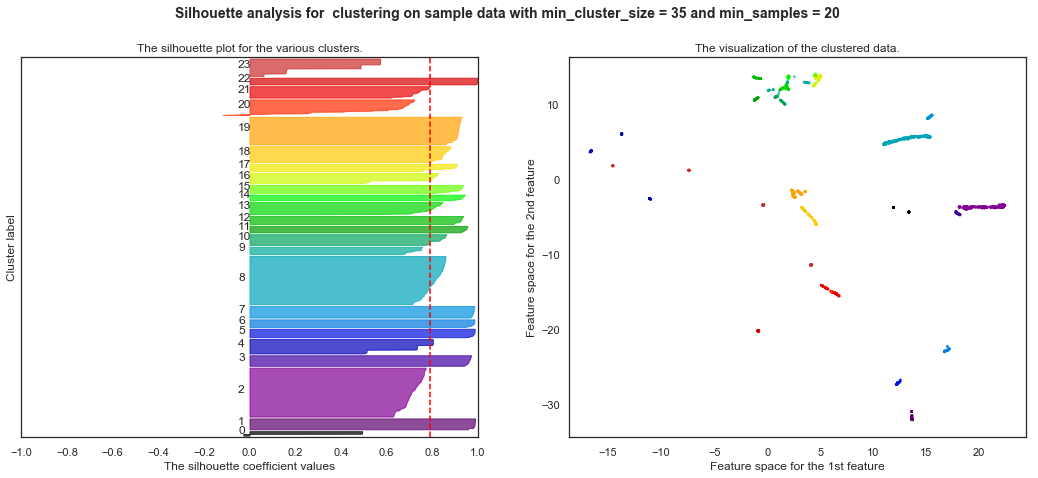

For min_cluster_size = 35 and min_samples = 25 
 There are this many clusters:  24 
 The average silhouette_score is : 0.7891988917202911


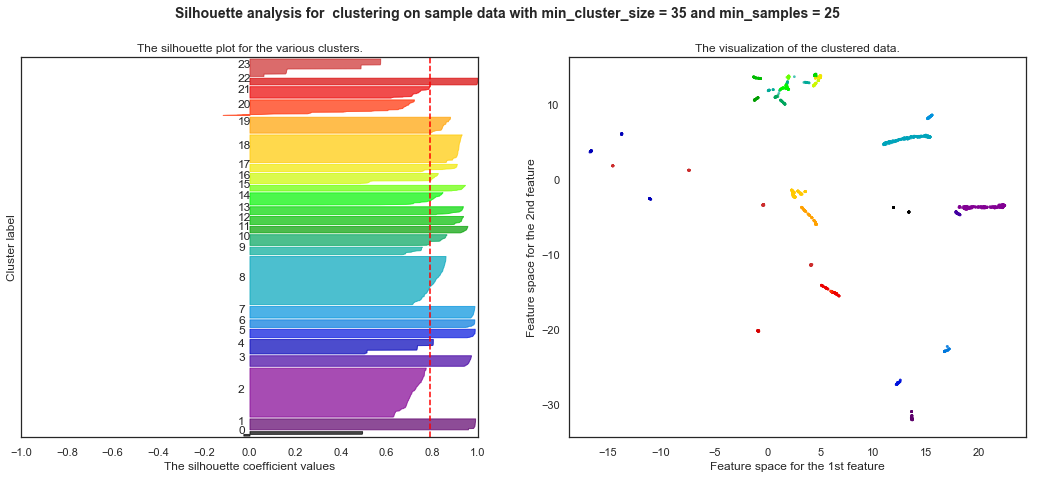

For min_cluster_size = 35 and min_samples = 30 
 There are this many clusters:  24 
 The average silhouette_score is : 0.7891988917202911


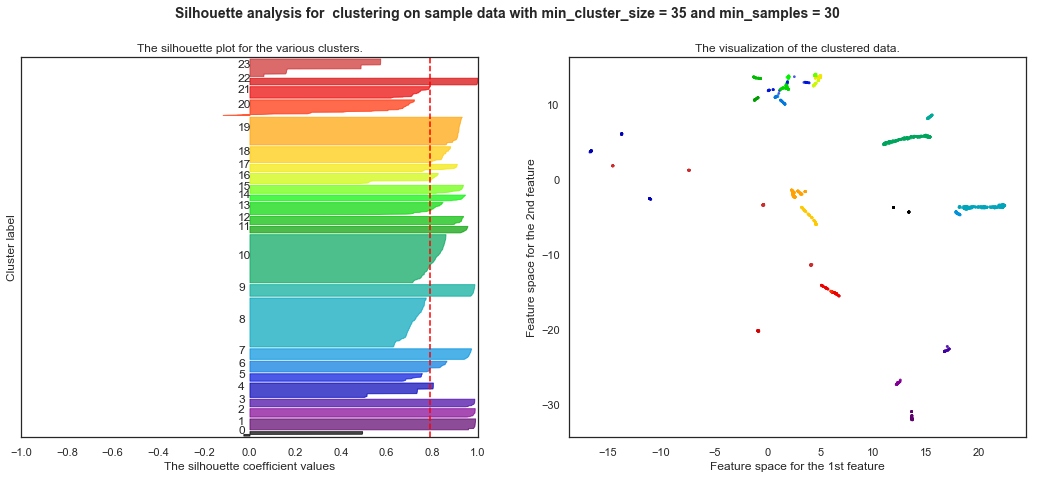

For min_cluster_size = 35 and min_samples = 35 
 There are this many clusters:  22 
 The average silhouette_score is : 0.7987732060125146


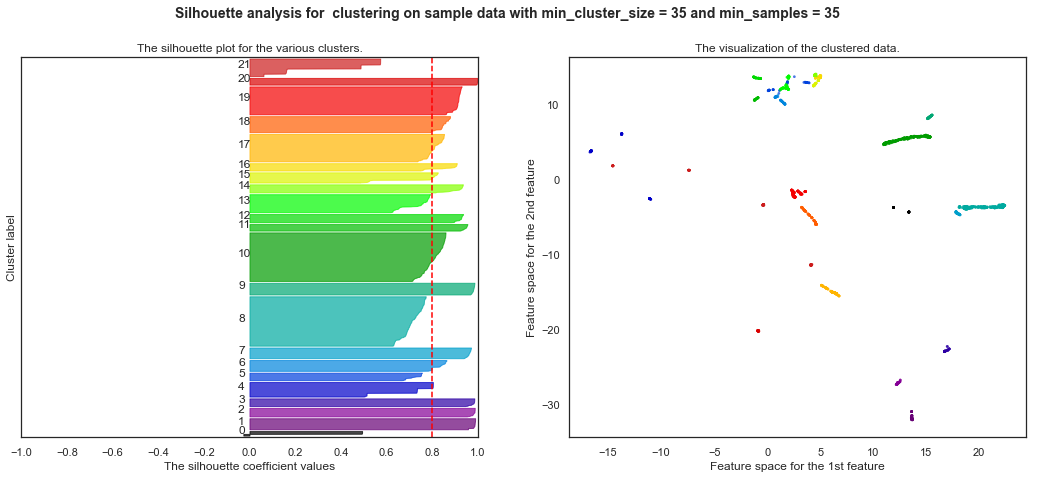

In [54]:
# Setup dataframe with results 
min_cluster_sizes = [10,15,20,25,30,35]
min_samples_l = [10,15,20,25,30,35]
def empty_col(): return [0 for o in range(len(min_cluster_sizes) * len(min_samples_l))]
results = pd.DataFrame({
    'min_cluster_size': empty_col(), 
    'min_samples': empty_col(), 
    'n_clusters': empty_col(),
    'silhouette_avg': empty_col(), 
    'percent_classified': empty_col()
})

## Clustering step 
# df is the dataframe with clustering 
i=0
for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_l:
        labels = hdbscan.HDBSCAN(min_samples=min_samples,
                                 min_cluster_size=min_cluster_size).fit_predict(df_coords)
        labels += 1 # remove -1 for no label 
        n_clusters, silhouette_avg, percent_classified = make_silhouette_plot(df_coords,labels)
        results.iloc[i, :] = [min_cluster_size, min_samples, n_clusters, silhouette_avg, percent_classified]
        i+=1 

In [56]:
# Pick out best result         
best = results.sort_values('silhouette_avg', ascending=False).iloc[0]
labels = hdbscan.HDBSCAN(min_samples=int(best['min_samples']), 
                         min_cluster_size=int(best['min_cluster_size'])).fit_predict(df_coords)
labels+=1  # deals with cluster -1 

# Add on cluster labels 
df_coords['cluster_label'] = [str(o) for o in labels]
df1['cluster_label'] = df_coords['cluster_label']

In [58]:
best

min_cluster_size      20.000000
min_samples           20.000000
n_clusters            29.000000
silhouette_avg         0.818418
percent_classified     0.979035
Name: 14, dtype: float64

## Collate, export 

In [76]:
df1.reset_index().to_csv('output_labels.tsv',sep='\t',index=False)
df_env_s.reset_index(drop=True).to_csv('output_vectors.tsv',sep='\t',
                                       header=False,index=False)

In [77]:
df1.cluster_label.value_counts()

9     297
18    292
13    168
12     97
10     95
1      76
27     74
17     71
11     70
2      67
20     62
7      52
24     50
19     49
8      47
22     46
21     45
25     41
3      41
23     40
15     37
6      36
28     35
0      32
5      31
16     28
26     25
4      24
14     23
Name: cluster_label, dtype: int64